# XRoration (XGate) - Data Analysis

## Configuration

Pulse and fidelity computation are computation intensive (slow).

In [1]:
PULSE_ENABLED = False
FIDELITY_ENABLED = True

Parameters are stored in a shared script.

In [2]:
from parameters import *

Using a shared location for datasets is better.

In [3]:
print('---------------------------------------')
print('List available datasets in', BASE_DIR)
!ls $BASE_DIR
print('---------------------------------------')

---------------------------------------
List available datasets in ../data_pulse/xrotation
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0001.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0002.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0003.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0004.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0005.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0006.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0007.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0008.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0009.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0010.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0011.csv
rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0012.csv
rx_test_c

## Library

In [4]:
import sys
sys.path.append('..')

from utils.helpers import *

## Dataset

### Load

In [5]:
import numpy as np
import pandas as pd
from IPython.display import display

Disable cell scrolling.

Load data that we generated with the _Juqbox.jl_ pulse optimizer and different seeds.

<span style="background-color:orange">How many Juqbox traces/seeds to use? Which granularity for the angles along x, y, and z axes?</span>

In [6]:
csv_files = [
    '{}/rx_test_configfile_config_template_{}.json_randomseed_{:04d}.csv'.format(BASE_DIR, CSV_CONFIG, i) for i in range(1, N_CSV_FILES+1)
]

df_list = []
df_test_list = []
for f in csv_files:
    df_list.append(pd.read_csv(f, header=None))

In [7]:
print('---------------------------------------')
for i in range(len(csv_files)):
    print(csv_files[i], df_list[i].shape)
print('---------------------------------------')
import os
if (os.path.isfile('../../' + CONFIG_TEMPLATE_JSON)):
    print('[Juqbox configuration] using: ', '../../' + CONFIG_TEMPLATE_JSON)
else:
    print('ERROR: File not found:', '../../' + CONFIG_TEMPLATE_JSON)
print('---------------------------------------')

---------------------------------------
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0001.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0002.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0003.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0004.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0005.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0006.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0007.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0008.csv (4096, 21)
../data_pulse/xrotation/rx_test_configfile_config_template_D1_10_Pmin_200.json_r

Concatenate the data sets.

In [8]:
# Compute the average of the first 20 columns (output) of the different seeds
averaged_columns = pd.concat([df.iloc[:, :20] for df in df_list]).groupby(level=0).mean()

# Take the 21st column (input) from the first DataFrame
last_column = df_list[0].iloc[:, 20]

# Combine them into a new DataFrame
avg_df = pd.concat([averaged_columns, last_column], axis=1)

In [9]:
import pandas as pd

def smooth_data_excluding_last_column(df, main_window_size=50):
    # Exclude the last column (input) during the smoothing process
    df_to_smooth = df.iloc[:, :-1]
    
    # Create a copy of the DataFrame to store the smoothed values
    smoothed_df = pd.DataFrame(index=df.index, columns=df.columns)

    # Perform the smoothing on each row
    for row in range(len(df_to_smooth)):
        # Calculate start and end indices for the smoothing window using main_window_size
        start = max(row - main_window_size // 2, 0)
        end = min(row + main_window_size // 2 + 1, len(df_to_smooth))
        
        # Calculate the smoothed values for the window
        window_mean = df_to_smooth.iloc[start:end].mean()
        
        # Assign the smoothed values to the corresponding row in the smoothed DataFrame
        smoothed_df.iloc[row, :-1] = window_mean

    # Reassign the last column to the original
    smoothed_df.iloc[:, -1] = df.iloc[:, -1]

    return smoothed_df

# Apply the smoothing function to the DataFrame
df_smoothed = smooth_data_excluding_last_column(avg_df)
df_smoothed.iloc[:, 10:20] = 0
# Now df_smoothed contains the smoothed data, excluding the last column in the calculation


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

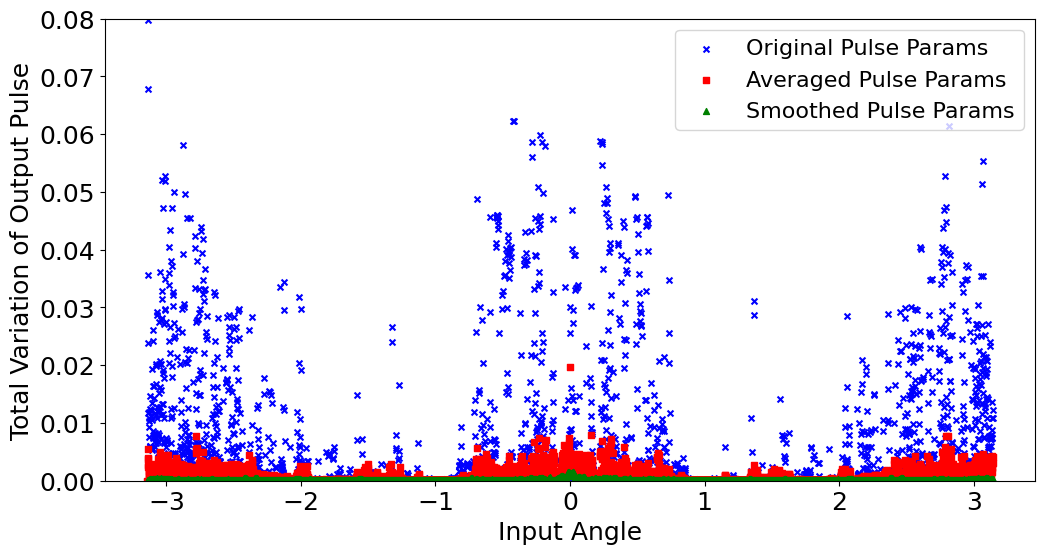

In [11]:
import matplotlib.pyplot as plt

# Assuming df_list[0], avg_df, and df_smoothed are predefined DataFrames with the required data

# Create 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Calculate the total variation on the original DataFrame
total_variations_original = df_list[0].iloc[:, :20].diff().abs()
total_variations_original['total_variation'] = total_variations_original.sum(axis=1)

# Calculate the total variation on the averaged DataFrame
total_variations_avg = avg_df.iloc[:, :20].diff().abs()
total_variations_avg['total_variation'] = total_variations_avg.sum(axis=1)

# Calculate the total variation on the smoothed DataFrame
total_variations_smoothed = df_smoothed.iloc[:, :20].diff().abs()
total_variations_smoothed['total_variation'] = total_variations_smoothed.sum(axis=1)

# Plot the total variations on the same figure
plt.figure(figsize=(12, 6))

# Plot 'Original Pulse Params' and 'Averaged Pulse Params' as line plots
plt.scatter(df_smoothed.iloc[:, 20], total_variations_original['total_variation'], color='blue', marker='x', label='Original Pulse Params', s=18)
plt.scatter(df_smoothed.iloc[:, 20], total_variations_avg['total_variation'], color='red', marker='s', label='Averaged Pulse Params', s=18)

# Plot 'Smoothed Pulse Params' as a scatter plot with increased point size
plt.scatter(df_smoothed.iloc[:, 20], total_variations_smoothed['total_variation'], color='green', marker='^', s=18, label='Smoothed Pulse Params') # You can adjust the size with the `s` parameter

plt.legend(fontsize=16)
plt.ylim([0, 0.08])
plt.xlabel('Input Angle', fontsize=18)
plt.ylabel('Total Variation of Output Pulse', fontsize=18)
#plt.title('Total Variation of Output Pulse', fontsize=16)
plt.tick_params(axis='both', labelsize=18)

plt.savefig('plots/total_variation_plot.png')
plt.show()


In [12]:
# Calculate the average for columns 2 to 8 for each row
average_of_params = df_smoothed.iloc[:, 2:8].mean(axis=1)

# Update columns 2 to 8 with the average value
df_smoothed.iloc[:, 2:8] = average_of_params.values.reshape(-1, 1)

In [13]:
# Create a new DataFrame with the desired structure
new_df = pd.DataFrame({
    'Param_1': df_smoothed.iloc[:, 0],           # Column 1 from the smoothed DataFrame
    'Param_2': df_smoothed.iloc[:, 1],           # Column 2 from the smoothed DataFrame
    'Average_Param_3_to_8': df_smoothed.iloc[:, 2],  # This will create columns 3 to 8
    'Param_9': df_smoothed.iloc[:, 8],           # Column 8 from the smoothed DataFrame
    'Param_10': df_smoothed.iloc[:, 9],          # Column 9 from the smoothed DataFrame
    'input': df_smoothed.iloc[:, -1]          # Last Column from the smoothed DataFrame
})

In [14]:
new_df.to_csv('new_df.csv', index=False)

In [15]:
pd.set_option('display.max_columns', None)  # No limit on the number of columns to display
pd.set_option('display.max_rows', 10)  # Limit to 10 rows for brevity in display
display(df_list[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.004955,-0.002237,-0.015215,-0.015346,-0.016977,-0.017048,-0.016196,-0.016919,-0.003211,0.004944,-0.002562,-0.003049,0.001254,0.001861,0.000607,-0.000988,-0.001514,-0.000377,0.001355,0.000501,-3.141593
1,0.004692,-0.006090,-0.016463,-0.014129,-0.017402,-0.017656,-0.013356,-0.013757,-0.005205,0.005314,0.001654,0.002889,-0.000516,-0.001639,0.000279,0.001176,-0.000456,-0.000040,0.001411,0.000309,-3.140058
2,0.001504,-0.007897,-0.010032,-0.011692,-0.019965,-0.020000,-0.012564,-0.011668,-0.010653,0.004206,-0.011305,-0.007604,0.005625,0.001543,-0.001010,-0.000510,-0.000515,-0.001142,-0.000871,-0.000137,-3.138524
3,0.006320,-0.002550,-0.015304,-0.014917,-0.017859,-0.018224,-0.015416,-0.015408,-0.004132,0.007471,0.004266,0.002137,-0.001981,-0.000115,0.000684,0.000171,-0.000410,-0.000039,0.001145,0.000461,-3.136990
4,0.003600,-0.003809,-0.015723,-0.015099,-0.016366,-0.016608,-0.015410,-0.015606,-0.004426,0.004392,0.000640,0.000768,-0.000839,-0.000923,-0.000091,0.000684,0.000727,-0.000287,-0.001211,-0.000198,-3.135455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.002848,0.003597,0.016107,0.015215,0.015880,0.016277,0.015701,0.015929,0.003964,-0.003533,0.001235,0.001240,-0.000454,-0.000605,-0.000258,0.000274,0.000593,0.000227,-0.000363,0.000005,3.135455
4092,-0.003613,0.002998,0.015754,0.015372,0.016984,0.017435,0.015748,0.015196,0.003267,-0.004351,0.002418,0.002838,-0.000818,-0.001468,-0.000750,0.000616,0.001533,0.000651,-0.001078,-0.000231,3.136990
4093,-0.003086,0.003161,0.015368,0.015399,0.016956,0.017039,0.015562,0.015562,0.003676,-0.003528,0.001933,0.002983,-0.000538,-0.002018,-0.001274,0.000937,0.002289,0.000598,-0.001921,-0.000436,3.138524
4094,-0.004085,0.001933,0.015344,0.015185,0.017001,0.017567,0.016494,0.016571,0.002597,-0.004336,0.002952,0.004649,-0.000881,-0.002754,-0.001388,0.001148,0.002576,0.001202,-0.002072,-0.000615,3.140058


In [16]:
display(avg_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.004788,-0.004689,-0.015495,-0.014330,-0.016909,-0.017202,-0.014794,-0.015623,-0.004654,0.004756,0.001948,0.001628,-0.000790,-0.000649,-0.000016,0.000358,0.000292,0.000169,0.000113,0.000074,-3.141593
1,0.004496,-0.004481,-0.015346,-0.014587,-0.017042,-0.017130,-0.014733,-0.015399,-0.004910,0.004886,0.001029,0.000721,-0.000457,-0.000249,0.000130,0.000188,-0.000063,-0.000023,0.000272,0.000128,-3.140058
2,0.004521,-0.004558,-0.015483,-0.014659,-0.016867,-0.016685,-0.014459,-0.015563,-0.005471,0.005258,0.001104,0.000764,-0.000452,-0.000288,0.000092,0.000227,-0.000003,-0.000056,0.000258,0.000139,-3.138524
3,0.004598,-0.004420,-0.015728,-0.014571,-0.016488,-0.016606,-0.014753,-0.015813,-0.005331,0.005496,0.001443,0.001113,-0.000735,-0.000509,0.000048,0.000360,0.000224,-0.000029,-0.000044,0.000054,-3.136990
4,0.004245,-0.004280,-0.015692,-0.014768,-0.016460,-0.016440,-0.014774,-0.015747,-0.005395,0.005349,0.000998,0.000634,-0.000414,-0.000147,0.000100,0.000109,-0.000038,0.000007,0.000259,0.000133,-3.135455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.003133,0.003668,0.015580,0.015080,0.016594,0.016550,0.015067,0.015606,0.004859,-0.004272,0.001188,0.001038,-0.000131,-0.000161,-0.000216,-0.000069,0.000240,0.000409,0.000299,0.000121,3.135455
4092,-0.003503,0.003866,0.015537,0.014861,0.016926,0.016852,0.014748,0.015463,0.004948,-0.004498,0.001822,0.001489,-0.000484,-0.000345,-0.000230,0.000027,0.000412,0.000441,0.000147,0.000092,3.136990
4093,-0.003810,0.003926,0.015455,0.014696,0.017135,0.017079,0.014654,0.015523,0.004854,-0.004623,0.001988,0.001507,-0.000717,-0.000470,-0.000273,0.000172,0.000608,0.000294,-0.000197,0.000031,3.138524
4094,-0.003964,0.004048,0.015597,0.014685,0.016983,0.017033,0.014818,0.015658,0.004491,-0.004381,0.002438,0.001964,-0.000811,-0.000563,-0.000273,0.000185,0.000603,0.000448,-0.000009,0.000048,3.140058


In [17]:
display(df_smoothed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.003613,-0.004382,-0.015432,-0.015432,-0.015432,-0.015432,-0.015432,-0.015432,-0.006242,0.005536,0,0,0,0,0,0,0,0,0,0,-3.141593
1,0.00358,-0.004385,-0.015419,-0.015419,-0.015419,-0.015419,-0.015419,-0.015419,-0.0063,0.005561,0,0,0,0,0,0,0,0,0,0,-3.140058
2,0.003541,-0.004389,-0.015405,-0.015405,-0.015405,-0.015405,-0.015405,-0.015405,-0.006361,0.005578,0,0,0,0,0,0,0,0,0,0,-3.138524
3,0.003523,-0.004378,-0.015396,-0.015396,-0.015396,-0.015396,-0.015396,-0.015396,-0.006413,0.005626,0,0,0,0,0,0,0,0,0,0,-3.13699
4,0.003492,-0.004375,-0.015384,-0.015384,-0.015384,-0.015384,-0.015384,-0.015384,-0.006468,0.005654,0,0,0,0,0,0,0,0,0,0,-3.135455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.002921,0.003916,0.015469,0.015469,0.015469,0.015469,0.015469,0.015469,0.006127,-0.005214,0,0,0,0,0,0,0,0,0,0,3.135455
4092,-0.002953,0.003896,0.015486,0.015486,0.015486,0.015486,0.015486,0.015486,0.006059,-0.005194,0,0,0,0,0,0,0,0,0,0,3.13699
4093,-0.002959,0.003891,0.015499,0.015499,0.015499,0.015499,0.015499,0.015499,0.005987,-0.005128,0,0,0,0,0,0,0,0,0,0,3.138524
4094,-0.002981,0.003871,0.015516,0.015516,0.015516,0.015516,0.015516,0.015516,0.00591,-0.005088,0,0,0,0,0,0,0,0,0,0,3.140058


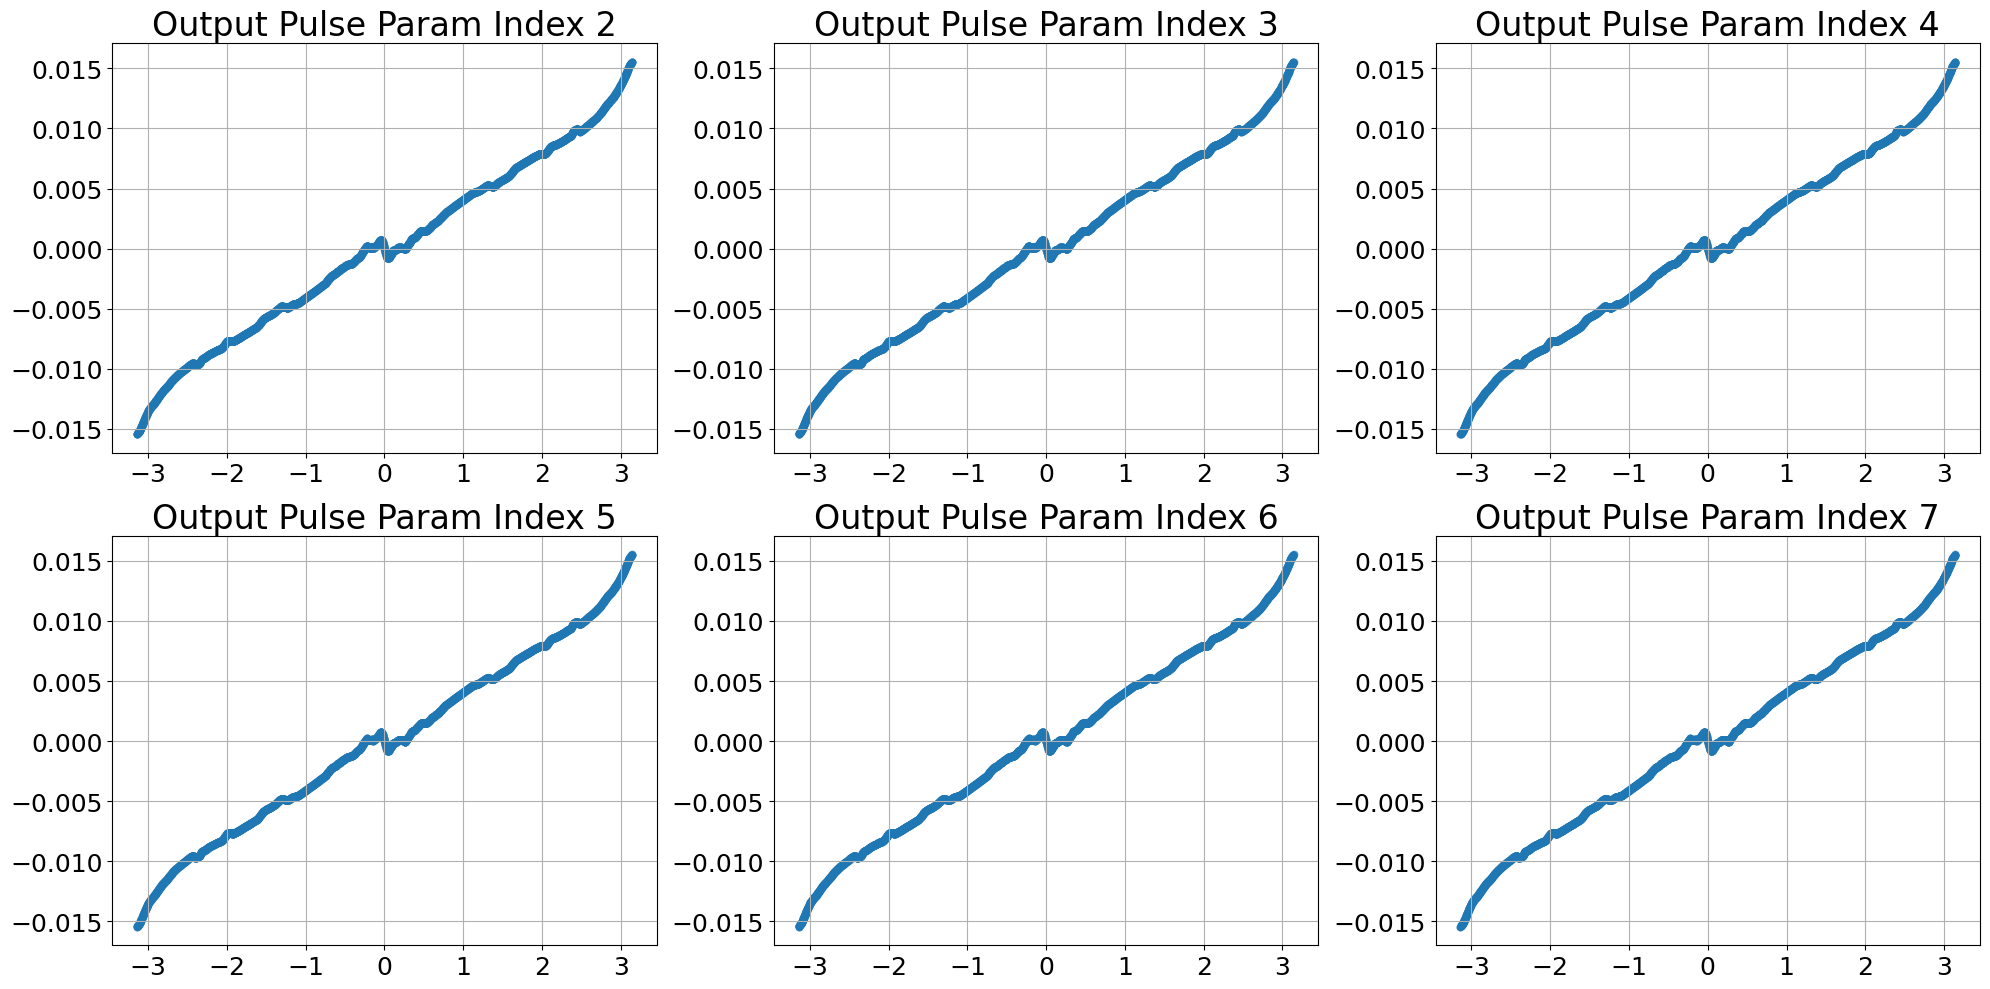

In [18]:
import matplotlib.pyplot as plt

# Create 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Number of output parameters to plot (indices 2 to 7)
start_index = 2
end_index = 7

# Create a figure with subplots
plt.figure(figsize=(20, 10))

# Assuming the last column of df is the input parameter
input_param = df_smoothed.iloc[:, -1]

# Loop over the specified range of indices
for i in range(start_index, end_index + 1):
    # Add a new subplot for each output parameter
    # Adjust the grid dimensions as needed (e.g., 2 rows, 3 columns for 6 plots)
    ax = plt.subplot(2, 3, i - start_index + 1)

    # Get the i-th output parameter
    output_param = df_smoothed.iloc[:, i]

    # Plotting
    ax.scatter(input_param, output_param, alpha=0.6, s=22)

    ax.set_title(f'Output Pulse Param Index {i}', fontsize=24)
    #ax.set_xlabel('Input Angle', fontsize=18)
    #ax.set_ylabel(f'Output Pulse Index {i} Value')
    plt.tick_params(axis='both', labelsize=18)
    ax.grid(True)

plt.tight_layout()
plt.savefig('plots/param_trend.png')
plt.show()

In [19]:
display(new_df)

,Param_1,Param_2,Average_Param_3_to_8,Param_9,Param_10,input
0,0.003613,-0.004382,-0.015432,-0.006242,0.005536,-3.141593
1,0.00358,-0.004385,-0.015419,-0.0063,0.005561,-3.140058
2,0.003541,-0.004389,-0.015405,-0.006361,0.005578,-3.138524
3,0.003523,-0.004378,-0.015396,-0.006413,0.005626,-3.13699
4,0.003492,-0.004375,-0.015384,-0.006468,0.005654,-3.135455
...,...,...,...,...,...,...
4091,-0.002921,0.003916,0.015469,0.006127,-0.005214,3.135455
4092,-0.002953,0.003896,0.015486,0.006059,-0.005194,3.13699
4093,-0.002959,0.003891,0.015499,0.005987,-0.005128,3.138524
4094,-0.002981,0.003871,0.015516,0.00591,-0.005088,3.140058


In [20]:
df = new_df

In [21]:
N_ANGLES = 1
N_PARAMS = df.shape[1]-N_ANGLES
#np.save("./data/xgate/{}/N_PARAMS.npy".format(CSV_CONFIG), N_PARAMS)
#print(N_PARAMS)
print('---------------------------------------')
print('Data set shape', df.shape)
print('- Entries              #', df.shape[0])
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 3 BETA VALUES (ANGLES ALONG X, Y, Z AXES)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 3 BETA VALUES (ANGLES ALONG X, Y, Z AXES)
print('---------------------------------------')

---------------------------------------
Data set shape (4096, 6)
- Entries              # 4096
- Pulse parameters (y) # 5
- Gate parameters  (x) # 1
---------------------------------------


Get maximum and minimum values for the alpha values that may help with plotting and such.

In [22]:
max_pparam_value = np.max(df.values[:,:N_PARAMS])
min_pparam_value = np.min(df.values[:,:N_PARAMS])

### Split

In [23]:
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

2024-04-20 15:15:43.607472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow ver. 2.11.0


In [24]:
from sklearn.model_selection import train_test_split

Dataset split is 60%-20%-20% training-validation-test set. We use a constant state (seed) for reproducible splits across multiple runs.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,N_PARAMS:N_PARAMS+N_ANGLES], df.iloc[:,:N_PARAMS], test_size=0.2, random_state=1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1, shuffle=True)

In [26]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2457, 1)
(819, 1)
(820, 1)


Let's have a look at the gate parameters (angles / betas) from the test set.

In [27]:
import matplotlib.animation as animation
from IPython.display import HTML

In [28]:
print('---------------------------------------')
print(x_test)
print('---------------------------------------')

---------------------------------------
         input
3962  2.937523
3000  1.461474
3919  2.871546
3654  2.464942
230  -2.788691
...        ...
2313  0.407371
3983  2.969745
3444  2.142727
3791  2.675149
2822  1.188358

[820 rows x 1 columns]
---------------------------------------


Let's have a look at the pulse parameters (alphas). Only the first element in the test set.

In [29]:
total = df.shape[0]
print('---------------------------------------')
print('Train set shape: {}, {:.2f}%'.format(y_train.shape, (y_train.shape[0]*100.)/total))
print('Validation set shape: {}, {:.2f}%'.format(y_val.shape, (y_val.shape[0]*100.)/total))
print('Test set shape: {}, {:.2f}%'.format(y_test.shape, (y_test.shape[0]*100.)/total))
print('---------------------------------------')

---------------------------------------
Train set shape: (2457, 5), 59.99%
Validation set shape: (819, 5), 20.00%
Test set shape: (820, 5), 20.02%
---------------------------------------


### Save

Always good to save the split data set for future reference.

In [30]:
!mkdir -p ./data/xrotation/$CSV_CONFIG 
np.save('./data/xrotation/{}/x_train.npy'.format(CSV_CONFIG), x_train)
np.save('./data/xrotation/{}/x_val.npy'.format(CSV_CONFIG), x_val)
np.save('./data/xrotation/{}/x_test.npy'.format(CSV_CONFIG), x_test)
np.save('./data/xrotation/{}/y_train.npy'.format(CSV_CONFIG), y_train)
np.save('./data/xrotation/{}/y_val.npy'.format(CSV_CONFIG), y_val)
np.save('./data/xrotation/{}/y_test.npy'.format(CSV_CONFIG), y_test)
print('Data saved in ./data/xrotation/{}/'.format(CSV_CONFIG))

Data saved in ./data/xrotation/D1_10_Pmin_200/


### Visualize

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Overall pulse parameter distribution.

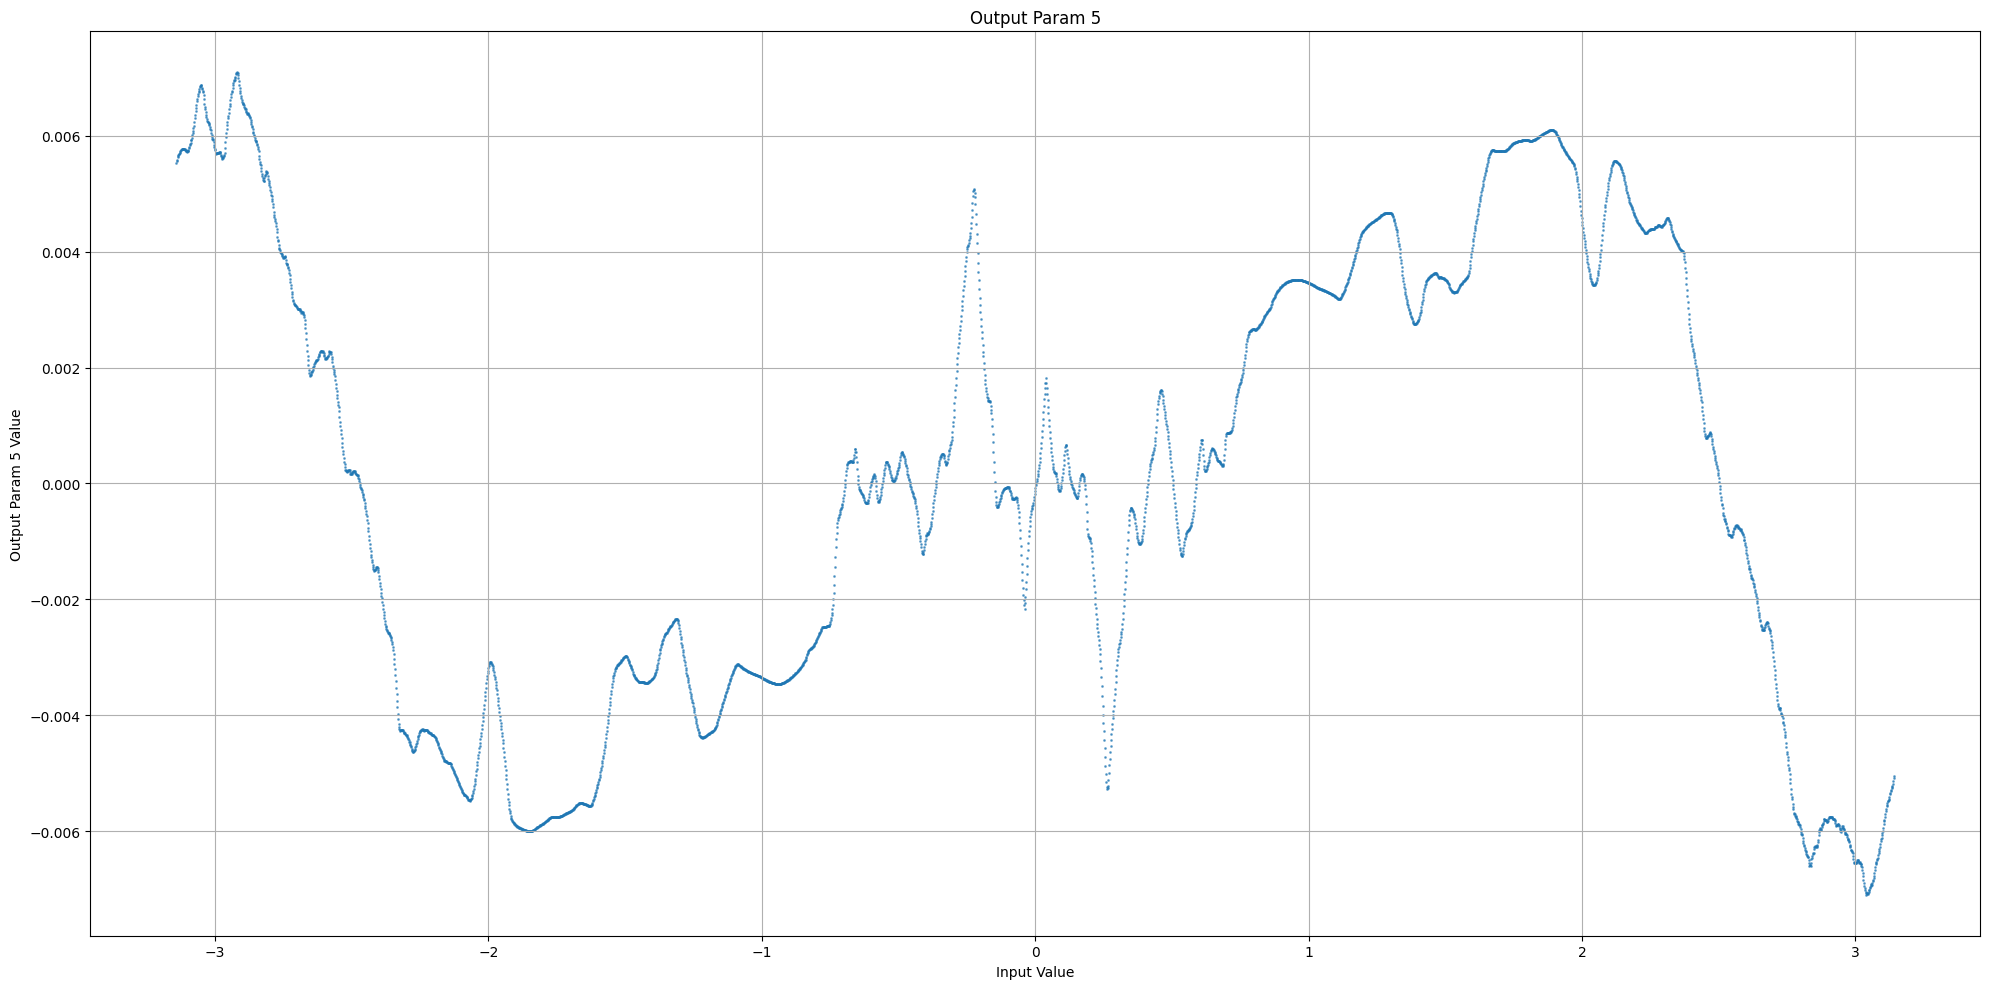

In [32]:
import matplotlib.pyplot as plt

# Number of output parameters to plot
num_output_params = 5

# Create a figure with subplots
plt.figure(figsize=(20, 10))

# Assuming the last column of df is the input parameter
input_param = df.iloc[:, -1]
i = 4
#for i in range(num_output_params):
    # Add a new subplot for each output parameter
ax = plt.subplot()  # Adjust the grid dimensions (1, 5) as needed

# Get the i-th output parameter
output_param = df.iloc[:, i]

# Plotting
ax.scatter(input_param, output_param, alpha=0.6, s=1)

ax.set_title(f'Output Param {i+1}')
ax.set_xlabel('Input Value')
ax.set_ylabel(f'Output Param {i+1} Value')
ax.grid(True)

plt.tight_layout()
plt.show()

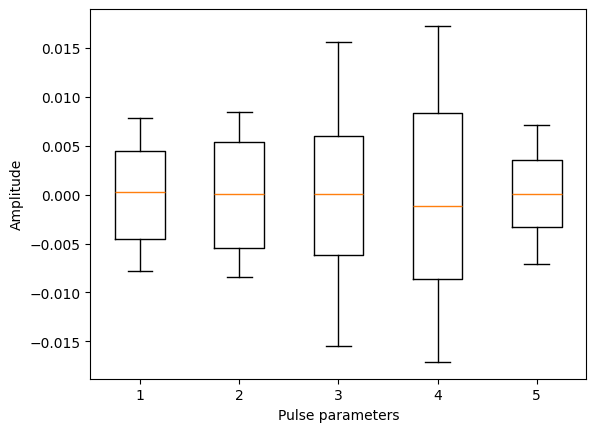

In [33]:
_ = plt.boxplot(df.iloc[:,:N_PARAMS], showfliers=True)
#_ = plt.boxplot(y_cleaned, showfliers=True)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Pulse parameters')

Creates an animation to display the pulse parameters for different gate params

In [34]:
## Needs ffmpeg. Install using "conda install -c conda-forge ffmpeg"
start_idx = 0
num_frames = 4096
frame_interval_ms = 10

# get x and y
x = np.arange(1, N_PARAMS+1, 1)
y = df.iloc[start_idx:start_idx+num_frames,:N_PARAMS].to_numpy()
beta = df.iloc[start_idx:start_idx+num_frames,N_PARAMS:].to_numpy()

# create a figure and an axis object
plt.ioff()
fig, ax = plt.subplots()

# set labels and plot limits
plt.ylabel('Pulse parameter values')
plt.xlabel('Pulse parameters (α[1:{}])'.format(N_PARAMS))
plt.ylim([min_pparam_value, max_pparam_value*5/4])
plt.xticks(x, x)

# initialize an empty line object
line, = ax.plot([], [], marker='o', linestyle='--', color='r')

# create a text object inside the axes
title = ax.text(0.05, 0.9, "", transform=ax.transAxes)

# define a function that updates the line object for each frame
def animate(i):
    title.set_text(f"Beta: {beta[i]}")
    # update line data
    line.set_data(x, y[i])
    return line,

# create an animation object using FuncAnimation
anim = animation.FuncAnimation(fig, animate,
                              frames=num_frames,
                              interval=frame_interval_ms,
                              repeat=False)

# show the animation
%matplotlib inline
HTML(anim.to_html5_video())

This is the first entry in the dataset.

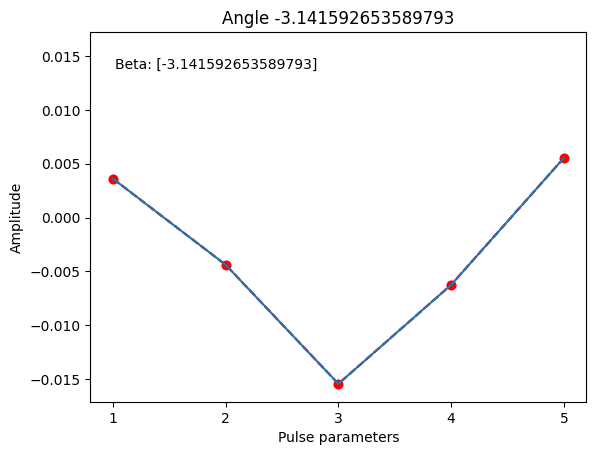

In [35]:
entry_id = 0

x = np.arange(1, N_PARAMS+1, 1)
y = df.iloc[entry_id:entry_id+1,:N_PARAMS].to_numpy()[0]
angle = df.iloc[entry_id:entry_id+1,N_PARAMS:N_PARAMS+1].to_numpy()[0][0]
plt.plot(x, y, marker='o', linestyle='--', color='r') 
plt.xticks(x, x)
plt.plot(x, y)
plt.title('Angle {}'.format(angle))
plt.ylabel('Amplitude')
plt.xlabel('Pulse parameters')
plt.ylim([min_pparam_value, max_pparam_value])
plt.show()

In [36]:
if PULSE_ENABLED:
    x = df.iloc[entry_id:entry_id+1,N_PARAMS:N_PARAMS+N_ANGLES].to_numpy()[0]
    y = df.iloc[entry_id:entry_id+1,:N_PARAMS].to_numpy()[0]

    plot_xgate_pulse(x, y, verbose=True)

This is the second entry in the dataset.

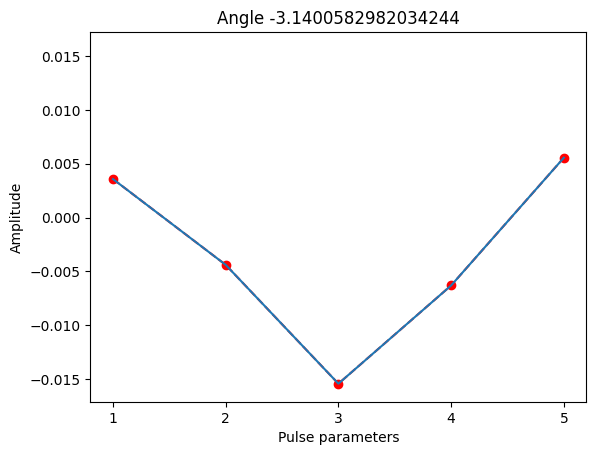

In [37]:
entry_id = 1

x = np.arange(1, N_PARAMS+1, 1)
y = df.iloc[entry_id:entry_id+1,:N_PARAMS].to_numpy()[0]
angle = df.iloc[entry_id:entry_id+1,N_PARAMS:N_PARAMS+1].to_numpy()[0][0]
plt.plot(x, y, marker='o', linestyle='--', color='r') 
plt.xticks(x, x)
plt.plot(x, y)
plt.title('Angle {}'.format(angle))
plt.ylabel('Amplitude')
plt.xlabel('Pulse parameters')
plt.ylim([min_pparam_value, max_pparam_value])
plt.show()

In [38]:
if PULSE_ENABLED:
    x = df.iloc[entry_id:entry_id+1,20:23].to_numpy()[0]
    y = df.iloc[entry_id:entry_id+1,:20].to_numpy()[0]

    plot_xgate_pulse(x, y, verbose=False)

Plot all of the entries in the dataset. It may take time, so disable it by default.

Fidelity of the train, validation, and test set.

<span style="color:red">ATTENTION: Measuring fidelity on the entire train, validation, and test sets could be time consuming. Use `limit` parameter in case.</span>

In [39]:
%%time
if FIDELITY_ENABLED:
    # Using some hash to avoid name collision
    import random
    hash_id = random.getrandbits(32)

    xgate_fidelity_train = get_xgate_fidelity(x_train.values,
                                              recover_original_structure(y_train.values),
                                              limit=len(x_train.values),
                                              config_template=CONFIG_TEMPLATE_JSON,
                                              pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                              output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
    xgate_fidelity_val = get_xgate_fidelity(x_val.values,
                                            recover_original_structure(y_val.values),
                                            limit=len(x_val.values),
                                            config_template=CONFIG_TEMPLATE_JSON,
                                            pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                            output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
    xgate_fidelity_test = get_xgate_fidelity(x_test.values,
                                             recover_original_structure(y_test.values),
                                             limit=len(x_test.values),
                                             config_template=CONFIG_TEMPLATE_JSON,
                                             pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                             output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))

    print('---------------------------------------')
    print('Config:', CONFIG_TEMPLATE_JSON)
    print('CSV file count:', N_CSV_FILES)
    print('Fidelity:')
    print('- train set:', xgate_fidelity_train)
    print('- test set:', xgate_fidelity_val)
    print('- val set:', xgate_fidelity_test)
    print('---------------------------------------')
else:
    xgate_fidelity_train = -1
    xgate_fidelity_val = -1
    xgate_fidelity_test = -1
    
    print('---------------------------------------')
    print('XGate fidelity: DISABLED')
    print('---------------------------------------')

---------------------------------------
Config: config_template_D1_10_Pmin_200.json
CSV file count: 100
Fidelity:
- train set: 0.9999720555830719
- test set: 0.9999713803493165
- val set: 0.9999708389903381
---------------------------------------
CPU times: user 76 ms, sys: 52 ms, total: 128 ms
Wall time: 1min 43s


As long as we use the same CSV files and same amount of them and the same `config_template_*.json` file (same Juqbox knobs), we should get the same values of fidelity.

|Config|granularity|CSV file count|train fidelity|test fidelity|val fidelity|notes|
|--|:--:|--:|:--|:--|:--|:--:|
|config_template_D1_10_Pmin_40.json|100|1|0.9992537820974491|0.9992047532282389|0.99915675532328|Older data|
|config_template_D1_10_Pmin_200.json|524288|1|0.9999790739188936|0.9999774997248378|0.9999779315427384|`limit=1000`|
|config_template_D1_10_Pmin_200.json|524288|1|0.9999781575811475|0.9999781817196898|0.9999782386830239||